# Assignment 4 - Michela Sessi 777760

Viene importato lo stesso dataset dell'assignment 3 in formato .tar e si utilizza la libreria tarfile per la gestione.

In [0]:
import tarfile

In [0]:
tar= tarfile.open("flowers.tar")
tar.extractall()
tar.close()

In [4]:
import numpy as np
import pandas as pd
from time import time
from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from random import shuffle
from keras.applications import vgg19
from keras.preprocessing import image as kimage
from keras.models import Model, load_model
from keras.layers import Dense
from keras import optimizers
from keras.optimizers import Adam
import random
import shutil
from numpy.random import seed
import os


Using TensorFlow backend.


Creo le cartelle necessarie e successivamente divido le immagini in training e test e viene eseguito il pre-processing necessario per passare le immaini alla rete VGG19.

In [0]:
# create validation set
os.mkdir("flowers/test")
os.mkdir("flowers/test/daisy")
os.mkdir("flowers/test/dandelion")
os.mkdir("flowers/test/rose")
os.mkdir("flowers/test/sunflower")
os.mkdir("flowers/test/tulip")

nomi = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

np.random.seed(46)
seed(46)

train_dir= 'flowers/flowers/'
test_dir= 'flowers/test/'

for i in nomi:
    source =train_dir + str(i)
    dest =test_dir+ str(i)
    files = os.listdir(source)
    files_s=random.sample(files, round(len(files)*0.25))
    for f in files_s:
        shutil.move(source + '/'+ f, dest + '/'+ f)

In [6]:
# Training set
datagen = kimage.ImageDataGenerator(preprocessing_function= vgg19.preprocess_input) 

train_generator = datagen.flow_from_directory(
        directory=train_dir,
        target_size=(224, 224), 
        color_mode="rgb",
        batch_size=81,
        class_mode="categorical",
        shuffle=True,
        seed=1
)


test_generator = datagen.flow_from_directory(
        directory=test_dir,
        target_size=(224, 224),  
        color_mode="rgb",
        batch_size=81,
        class_mode="categorical",
        shuffle=False, 
        seed=1
)


Found 3241 images belonging to 5 classes.
Found 1082 images belonging to 5 classes.


Carico la rete VGG19 escudendo gli strati fully connected con pooling average. Aggiungiamo quindi due strati con funzione di attivazione relu il primo con 1024 neuroni e il secondo con 512 neuroni. In ultimo passaggio si aggiunge uno strato con funzione di attivazione softmax con 5 neuroni, uno per ogni modalità di fiore.
L'ottimizzatore scelto è adam con funzione di perdita categorical crossentropy e accuracy come metrica.

In [0]:
net = vgg19.VGG19(weights='imagenet', include_top=False, pooling='avg', input_shape= (224, 224, 3)) 

for layer in net.layers:
    layer.trainable = False
# Recupera l'output del modello di base
x = net.output

# Aggiungi livello fully-connected intermedio + ReLU
x = Dense(1024, activation='relu')(x) 
x = Dense(512, activation='relu')(x)

pred = Dense(5, activation='softmax')(x)

my_net = Model(inputs= net.input, outputs=pred)

my_net.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])

Alleno la rete su 20 epoche con 40 steps_per_epoch. Per ogni epoca vengono riportati i valori di accuracy e di loss sia per il training che per il nostro test.

In [31]:
history = my_net.fit_generator(train_generator, steps_per_epoch=40, epochs=20,
                   validation_data = test_generator, validation_steps=10)

Epoch 1/20
40/40 [==============================] - 47s 1s/step - loss: 3.4182 - acc: 0.6541 - val_loss: 4.6104 - val_acc: 0.5593
Epoch 2/20
40/40 [==============================] - 44s 1s/step - loss: 2.9779 - acc: 0.7492 - val_loss: 0.4017 - val_acc: 0.8747
Epoch 3/20
40/40 [==============================] - 45s 1s/step - loss: 2.8837 - acc: 0.7840 - val_loss: 4.1993 - val_acc: 0.6623
Epoch 4/20
40/40 [==============================] - 44s 1s/step - loss: 3.1413 - acc: 0.7878 - val_loss: 4.1854 - val_acc: 0.6702
Epoch 5/20
40/40 [==============================] - 45s 1s/step - loss: 3.0632 - acc: 0.8045 - val_loss: 3.4342 - val_acc: 0.7259
Epoch 6/20
40/40 [==============================] - 44s 1s/step - loss: 3.0169 - acc: 0.7464 - val_loss: 1.0270 - val_acc: 0.8470
Epoch 7/20
40/40 [==============================] - 44s 1s/step - loss: 2.6949 - acc: 0.8172 - val_loss: 4.2039 - val_acc: 0.6741
Epoch 8/20
40/40 [==============================] - 45s 1s/step - loss: 2.7609 - acc: 0.82

Plottiamo due grafici per vedere l'andamento della loss e dell'accuracy per ogni epoca.

Text(0.5, 1.0, 'Accuracy Curves')

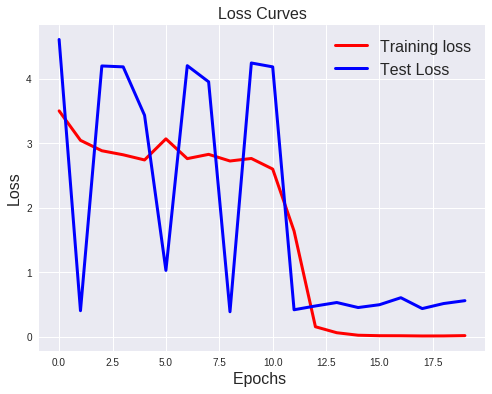

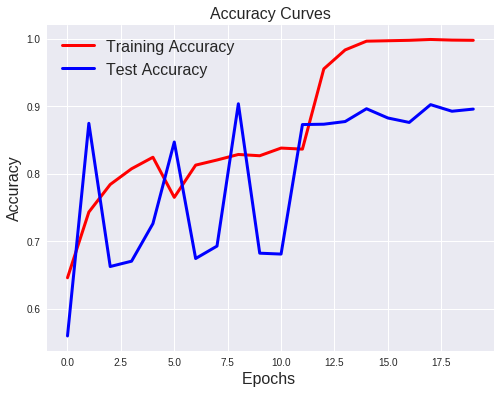

In [32]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Test Loss'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)
 
# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Test Accuracy'],fontsize=16)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

Riportiamo quindi l'accuracy media finale sul test.

In [60]:
print("Accuracy media: " + str(round(history.history["val_acc"][19],2)) + "0")

Accuracy media: 0.90
